### the function to extract voltage, current and power readings from log file

In [13]:
from datetime import datetime
from datetime import timedelta
import numpy as np
smooth_N = 10 # add smoothing
def read_file(file_path):
    '''
    Extrace voltage, current and power traces under a smoothing factor.
    Calculate the energy cumulating trace and add it as another column in trace.
    '''
    trace = []
    with open(file_path, 'r') as f:
        # extract start time from start time
        first_line = f.readline()
        data = first_line.strip().split(',')
        start_time = datetime.strptime(data[0], '%H:%M:%S.%f')
        last_time = start_time
        negFlag = False # use a flag to avoid loops
        breakFlag = False
        energy = 0.0
        while True:
            buf = []
            for i in range(0, smooth_N):
                line = f.readline()
                data = line.strip().split(',')
                cur_time = datetime.strptime(data[0], '%H:%M:%S.%f')
                # elapsed time in hours
                elapsed_time_h = (cur_time - start_time).total_seconds() / 3600
                # delta time in seconds
                delta_h = (cur_time - last_time).total_seconds() / 3600
                delta_h = max(delta_h, 0) # gurantee delta time is positive
                last_time = cur_time
                if elapsed_time_h < 0:
                    # add another day to avoid negative elapsed time
                    negFlag = True
                    elapsed_time_h += 24
                elif negFlag == True and elapsed_time_h > 0:
                    # finish processing all the data, end the loop
                    breakFlag = True
                    break

                # process voltage, current and power data
                volt = float(data[1]) # V
                curr = float(data[2]) # mA
                pwr = float(data[3]) # mW
                energy += (curr * delta_h) # mAh
                buf.append([elapsed_time_h, volt, curr, pwr, energy])
            
            # use the average
            if len(buf) != 0: # buf is not empty
                buf = np.array(buf)
                trace.append(np.mean(buf, axis=0))
            
            if breakFlag:
                break
    return np.array(trace)

### get the readings using only battery

In [14]:
bat_bat = read_file('./data/bat_bat.txt')
dev_bat = read_file('./data/dev_bat.txt')

### get the readings using battery and solar panel

In [15]:
bat_solar = read_file('./data/bat_solar.txt')
dev_solar = read_file('./data/dev_solar.txt')
solar_solar = read_file('./data/solar_solar.txt')

### plot the voltage of battery, device and solar panel

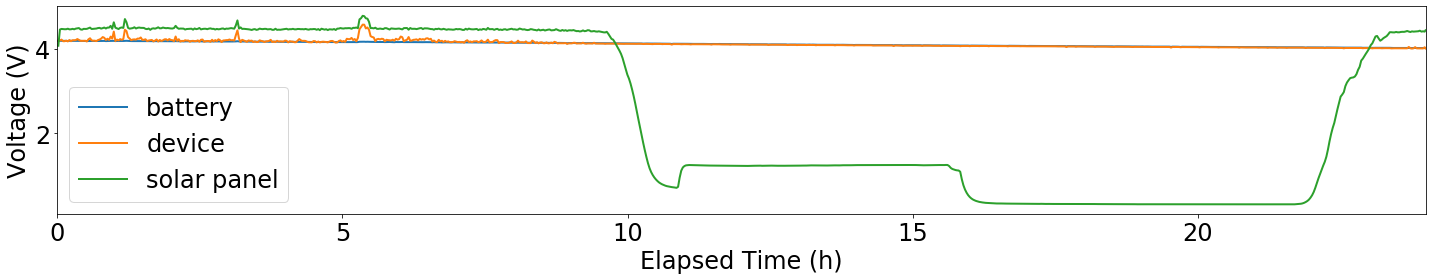

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.plot(bat_solar[:, 0], bat_solar[:, 1], linewidth=2.0, label='battery')
plt.plot(dev_solar[:, 0], dev_solar[:, 1], linewidth=2.0, label='device')
plt.plot(solar_solar[:, 0], solar_solar[:, 1], linewidth=2.0, label='solar panel')
plt.xlim((0, 24))
plt.xlabel('Elapsed Time (h)', fontsize=24)
plt.ylabel('Voltage (V)', fontsize=24)
plt.tick_params(labelsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig('./img/volt.png', dpi=300)

### plot the current of battery, device and solar panel

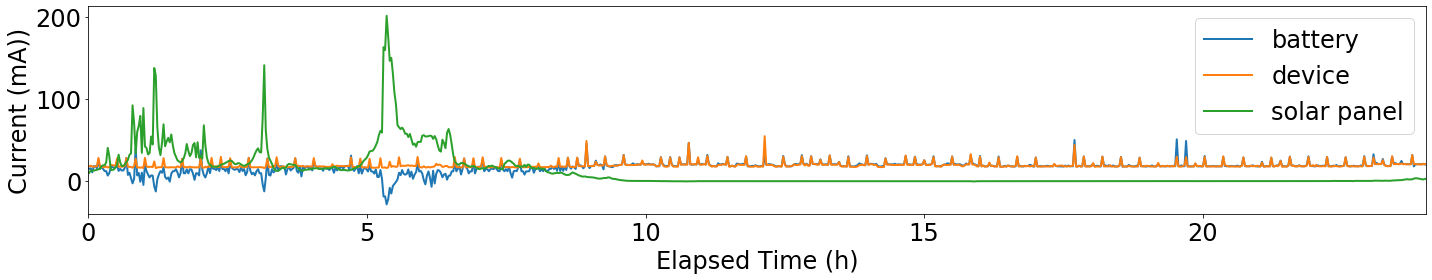

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(bat_solar[:, 0], bat_solar[:, 2], linewidth=2.0, label='battery')
plt.plot(dev_solar[:, 0], dev_solar[:, 2], linewidth=2.0, label='device')
plt.plot(solar_solar[:, 0], solar_solar[:, 2], linewidth=2.0, label='solar panel')
plt.xlim((0, 24))
plt.xlabel('Elapsed Time (h)', fontsize=24)
plt.ylabel('Current (mA))', fontsize=24)
plt.tick_params(labelsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig('./img/curr.png', dpi=300)

### plot the voltage of battery and device with pure battery supply

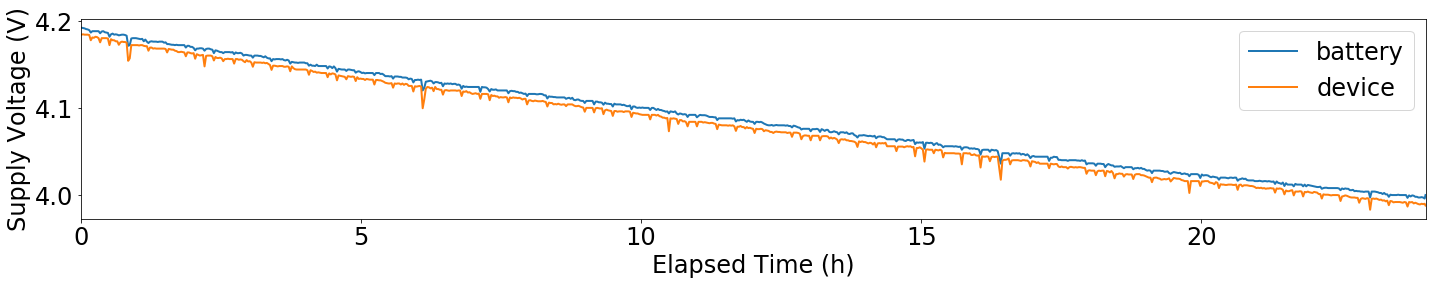

In [18]:
plt.figure(figsize=(20, 4))
plt.plot(bat_bat[:, 0], bat_bat[:, 1], linewidth=2.0, label='battery')
plt.plot(dev_bat[:, 0], dev_bat[:, 1], linewidth=2.0, label='device')
plt.xlim((0, 24))
plt.xlabel('Elapsed Time (h)', fontsize=24)
plt.ylabel('Supply Voltage (V)', fontsize=24)
plt.tick_params(labelsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig('./img/volt_bat.png', dpi=300)

### plot the current of battery and device with pure battery supply

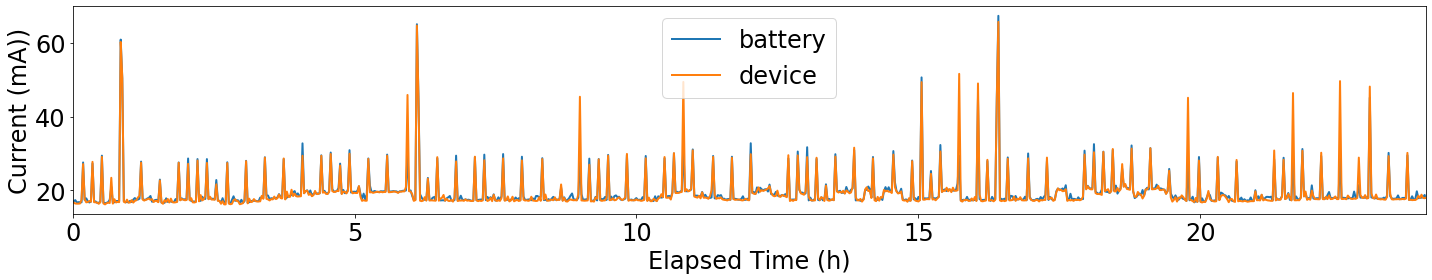

In [19]:
plt.figure(figsize=(20, 4))
plt.plot(bat_bat[:, 0], bat_bat[:, 2], linewidth=2.0, label='battery')
plt.plot(dev_bat[:, 0], dev_bat[:, 2], linewidth=2.0, label='device')
plt.xlim((0, 24))
plt.xlabel('Elapsed Time (h)', fontsize=24)
plt.ylabel('Current (mA))', fontsize=24)
plt.tick_params(labelsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig('./img/curr_bat.png', dpi=300)

### plot the energy draw from battery with or without solar panel

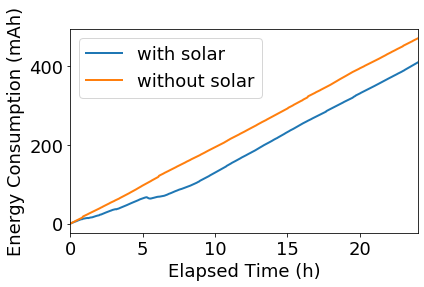

In [20]:
plt.figure()
plt.plot(bat_solar[:, 0], bat_solar[:, 4], linewidth=2.0, label='with solar')
plt.plot(bat_bat[:, 0], bat_bat[:, 4], linewidth=2.0, label='without solar')
plt.xlim((0, 24))
plt.xlabel('Elapsed Time (h)', fontsize=18)
plt.ylabel('Energy Consumption (mAh)', fontsize=18)
plt.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('./img/energy.png', dpi=300)

In [21]:
# print estimated lifetime in two cases
energy_w = bat_solar[-1, 4] # total energy consumption in one day with solar panel
energy_wo = bat_bat[-1, 4] # total energy consumption in one day without solar panel
print('Energy consumption in one day with solar panel: %.4f mAh' % energy_w)
print('Energy consumption in one day without solar panel: %.4f mAh' % energy_wo)
capacity = 1800 # 1800 mAh
lifetime_w = capacity / energy_w
lifetime_wo = capacity / energy_wo
print('Estimated lifetime with solar panel: %.4f days' % lifetime_w)
print('Estimated lifetime without solar panel: %.4f days' % lifetime_wo)
print('Lifetime improvement in percentage: %.4f' % ((lifetime_w - lifetime_wo) / lifetime_wo * 100))

Energy consumption in one day with solar panel: 408.9866 mAh
Energy consumption in one day without solar panel: 470.0736 mAh
Estimated lifetime with solar panel: 4.4011 days
Estimated lifetime without solar panel: 3.8292 days
Lifetime improvement in percentage: 14.9362
